### importing necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'C:\\Users\\Vinayak\\OneDrive\Desktop\\Sourabh project\\dataset\\train'  
validation_data_dir = 'C:\\Users\\Vinayak\\OneDrive\Desktop\\Sourabh project\\dataset\\validation'  
test_data_dir = 'C:\\Users\\Vinayak\\OneDrive\Desktop\\Sourabh project\\dataset\\test'
   
# number of epochs to train top model  
epochs = 7 #this can been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet') 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  

# Creation of weights/features with VGG16

In [5]:


start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 10 images belonging to 6 classes.


C:\Users\Vinayak\anaconda3\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Time:  0:00:07.638421


In [7]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 10 images belonging to 6 classes.
Time:  0:00:00.253623


In [9]:

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 10 images belonging to 6 classes.
Time:  0:00:00.260019


# Loading training, validation and testing data

In [10]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 10 images belonging to 6 classes.


In [11]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 10 images belonging to 6 classes.


In [12]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 10 images belonging to 6 classes.


# Training of model

In [13]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=7,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

C:\Users\Vinayak\anaconda3\envs\Tensorflow\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/7
1/1 [==============================] - 1s 939ms/step - loss: 2.6285 - acc: 0.2000 - val_loss: 1.5562 - val_acc: 0.3000
Epoch 2/7
1/1 [==============================] - 0s 45ms/step - loss: 1.7258 - acc: 0.3000 - val_loss: 0.9758 - val_acc: 0.7000
Epoch 3/7
1/1 [==============================] - 0s 37ms/step - loss: 1.2099 - acc: 0.6000 - val_loss: 0.7830 - val_acc: 0.9000
Epoch 4/7
1/1 [==============================] - 0s 42ms/step - loss: 1.1974 - acc: 0.5000 - val_loss: 0.6873 - val_acc: 1.0000
Epoch 5/7
1/1 [==============================] - 0s 40ms/step - loss: 1.0236 - acc: 0.7000 - val_loss: 0.5454 - val_acc: 1.0000
Epoch 6/7
1/1 [==============================] - 0s 44ms/step - loss: 1.2252 - acc: 0.6000 - val_loss: 0.4131 - val_acc: 1.0000
Epoch 7/7
1/1 [==============================] - 0s 19ms/step - loss: 0.3489 - acc: 1.0000
[INFO] accuracy: 100.00%
[INFO] Loss: 0.34888386726379395
Time:  0:00:01.399889


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 2,514,256
Trainable params: 2,514,256
Non-trainable params: 0
______________________________________________

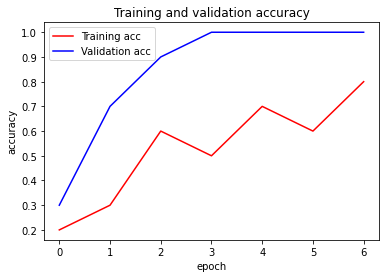

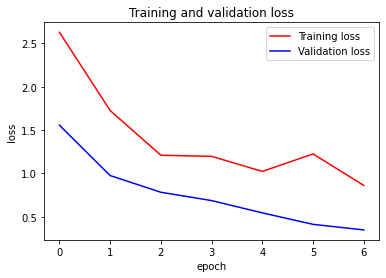

In [15]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

## Model Evaluation on Testing Set

In [16]:
model.evaluate(test_data, test_labels)

1/1 [==============================] - 0s 31ms/step - loss: 0.3489 - acc: 1.0000


[0.34888386726379395, 1.0]

## Classification metrics and Confusion Matrix

### Classification Metrics

In [17]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[8.46596956e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.11044908e-01 0.00000000e+00]
   [1.33076757e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.02504992e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.12690294e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.90772295e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.06664681e-01 0.00000000e+00]
   [1.32140309e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    7.84952343e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.03830338e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.48627436e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.89884698e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+0

In [18]:
Fassion = ['Ankle boot', 'Bag', 'Dress', 'Pullover', 'Sandal', 't-shirts']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=Fassion )
print(classification_metrics)

              precision    recall  f1-score   support

  Ankle boot       1.00      1.00      1.00         1
         Bag       1.00      1.00      1.00         1
       Dress       1.00      1.00      1.00         2
    Pullover       1.00      1.00      1.00         1
      Sandal       1.00      1.00      1.00         2
    t-shirts       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10
 samples avg       1.00      1.00      1.00        10



### Confusion Matrix

In [19]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [20]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [21]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


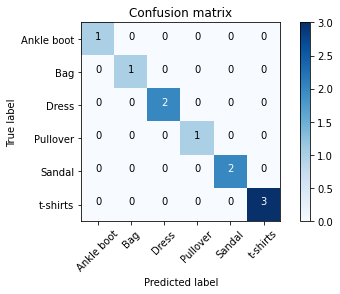

In [22]:
plot_confusion_matrix(confusion_matrix, ['Ankle boot', 'Bag', 'Dress', 'Pullover', 'Sandal', 't-shirts'])

Normalized confusion matrix


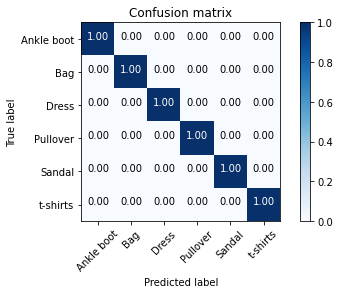

In [23]:
plot_confusion_matrix(confusion_matrix, 
                      ['Ankle boot', 'Bag', 'Dress', 'Pullover', 'Sandal', 't-shirts'],
                     normalize=True)

## Testing images on model

In [24]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [32]:
def test_single_image(path):
    Fassions = ['Ankle boot', 'Bag', 'Dress', 'Pullover', 'Sandal', 't-shirts']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)

    for idx, fassion, x in zip(range(0,6), Fassions , preds[0]):
        
        print("ID: {}, Label: {} {}%".format(idx, fassion, round(x*100,2) ))
       
    print('Final Decision:')
    time.sleep(.5)
    if (round(x*100,2)>20):
        print("NOt in the list")
        
    else:
        for x in range(3):
            print('.'*(x+1))
            time.sleep(.2)
        class_predicted = model.predict_classes(bt_prediction)
        class_dictionary = generator_top.class_indices  
        inv_map = {v: k for k, v in class_dictionary.items()}  
        print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
        return load_img(path)
        

In [41]:
path = 'C:\\Users\\Vinayak\\OneDrive\\Desktop\\Sourabh project\\dataset\\test\\11.jpg  '#add test path for test images

In [42]:
test_single_image(path)

[INFO] loading and preprocessing image...
ID: 0, Label: Ankle boot 4.31%
ID: 1, Label: Bag 8.83%
ID: 2, Label: Dress 22.81%
ID: 3, Label: Pullover 11.48%
ID: 4, Label: Sandal 15.36%
ID: 5, Label: t-shirts 37.2%
Final Decision:
NOt in the list
